In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from bs4 import BeautifulSoup
from urllib.request import urlopen
import datetime

# Functions

In [3]:
def get_close(tickers,
              start=datetime.date(datetime.date.today().year - 1, 
                datetime.date.today().month, 
                datetime.date.today().day)
                ,end=datetime.date.today()):
    
    data=pd.DataFrame()
    for ticker in tickers:

        try:

            yahoo_data=yf.Ticker(ticker)
            stock_price=yahoo_data.history(start=start,end=end,interval='1d').reset_index()
            stock_price['Date']=stock_price['Date'].dt.tz_localize(None)
            stock_price=stock_price.set_index('Date')
            stock_price[ticker]=stock_price['Close']+stock_price['Dividends'].shift(periods=-1)
            data=pd.concat([data,stock_price[ticker]],axis=1)

        except Exception as e:
            pass
        
    return data

In [4]:
def get_mrat(dataframe,numerator=21,denominator=200):

    mrat=(dataframe.rolling(numerator).mean()/dataframe.rolling(denominator).mean())
    mrat_wo_na=mrat.dropna(how='all')

    month=list(sorted(set(mrat_wo_na.index + pd.offsets.BMonthEnd(0))))
    #month_end=pd.to_datetime(mrat_wo_na.index)
    month = pd.to_datetime(month)

    idx1 = pd.Index(mrat_wo_na.iloc[:-1].index)
    idx2 = pd.Index(month)
    closest_dates = idx1[idx1.get_indexer(idx2, method='nearest')]


    mrat_weights=mrat_wo_na.loc[closest_dates].copy().fillna(0)
    
    mrat_weights['Total']=mrat_weights.sum(axis=1)

    for col in mrat_weights.columns:
        mrat_weights[col]=mrat_weights[col]/mrat_weights['Total']

    mrat_weights=mrat_weights.drop(columns='Total')
    mrat_weights_dict=mrat_weights.transpose().to_dict()

    dates_end=list(mrat_weights.index)
    dates_end.insert(0,dataframe.index[0])
    dates_end.append(dataframe.index[-1])
    dates_end=list(set(dates_end))
    
    return mrat_weights,sorted(dates_end)

In [5]:
def get_portfolios(mrat_weights,dates_end,dataframe,weight_dict,
                   numbers_of_stocks=50,
                   investment_amount=10000,
                   transaction_fee=0.005):
    tracking={}
    portfolio={}
    initial_amount=investment_amount
    perf=dataframe.pct_change()
    
    for i in range(len(dates_end)-1):
        
        print(dates_end[i],investment_amount,investment_amount/initial_amount)

        
        temp=dataframe.loc[dates_end[i]:dates_end[i+1]].copy()
        initial_price=temp.iloc[0].to_dict()

        if dates_end[i]>dates_end[0]:

            top50=mrat_weights.loc[dates_end[i]].sort_values(ascending=False)[:numbers_of_stocks]
            top_50_rebased=top50/top50.sum()
            top_50_dict=top_50_rebased.to_dict()

            weight_dict={}

            for key in temp.columns:

                if key in top_50_dict: 
                    weight_dict[key]=top_50_dict[key]
                else:
                    weight_dict[key]=0
                    
                    
        weight_vec=np.array(list(weight_dict.values()))
        
        inital_investment_per_stock={}
        shares={}

        for col in temp.columns:
            
            weighted_perf=weight_vec*perf.loc[dates_end[i]]
            
            inital_investment_per_stock[col]=weight_dict[col]*investment_amount*(1+weighted_perf.sum())
            shares[col]=inital_investment_per_stock[col]*(1-transaction_fee)/initial_price[col]

        tracking[dates_end[i]]=(weight_dict,shares,investment_amount,initial_price)

        temp=temp*shares    
        portfolio[dates_end[i]]=temp
        investment_amount=temp.iloc[-1].sum()
        
    
    temp=dataframe.loc[dates_end[-2]:]*shares
    portfolio[dates_end[-1]]=temp
        

    return portfolio,tracking


In [6]:
def get_pnl(portfolios):

    pnl={}

    keys=list(portfolio.keys())
    for i in range(len(keys)):

        if i>0:
            pnl[keys[i]]=portfolio[keys[i]].iloc[-1]-portfolio[keys[i]].iloc[0]

        else:
            
            pnl[keys[0]]=portfolio[keys[0]].iloc[-1]-portfolio[keys[0]].iloc[0]
    
    pnl_dataframe=pd.DataFrame(pnl).cumsum(axis=1).T
    
    return pnl_dataframe.iloc[:-2]

# Dataset

In [8]:
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
table = pd.read_html(url)
df = table[0]
tickers=df['Symbol'].tolist()

end_date = datetime.datetime.now().strftime("%Y-%m-%d")
start_date = (datetime.datetime(2019,6,15)).strftime("%Y-%m-%d")
#analysis_start_date = (datetime.datetime.now() - datetime.timedelta(days=365*4)).strftime("%Y-%m-%d")

dataframe=get_close(tickers,start=start_date,end=end_date)
dataframe.index=pd.to_datetime(dataframe.index)

$BRK.B: possibly delisted; no timezone found
$BF.B: possibly delisted; no price data found  (1d 2019-06-15 -> 2025-02-05)


In [9]:
sp500=get_close(['SPY'],start=start_date,end=end_date)
sp500_leverage=get_close(['XS2D.L'],start=start_date,end=end_date)

# Analysis

In [11]:
weight_dict={col: 1/dataframe.shape[1] for col in dataframe.columns}
mrat_weights,dates_end=get_mrat(dataframe,numerator=21,denominator=200)

C:\Users\niroo\AppData\Local\Temp\ipykernel_192248\2990283602.py:23: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  mrat_weights_dict=mrat_weights.transpose().to_dict()


In [12]:
mrat_weights = mrat_weights[~mrat_weights.index.duplicated(keep='first')]

In [13]:
portfolio,tracking=get_portfolios(investment_amount=100,dataframe=dataframe,numbers_of_stocks=10,weight_dict=weight_dict,
                                  mrat_weights=mrat_weights,dates_end=dates_end,
                                  transaction_fee=0.005)

C:\Users\niroo\AppData\Local\Temp\ipykernel_192248\1089267729.py:8: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  perf=dataframe.pct_change()


2019-06-17 00:00:00 100 1.0
2020-03-31 00:00:00 83.91345529983212 0.8391345529983212
2020-04-30 00:00:00 103.46187843006085 1.0346187843006085
2020-05-29 00:00:00 114.18644865756896 1.1418644865756895
2020-06-30 00:00:00 121.15634728270916 1.2115634728270916
2020-07-31 00:00:00 143.8201838409922 1.438201838409922
2020-08-31 00:00:00 165.69042473541418 1.6569042473541418
2020-09-30 00:00:00 164.76635623366826 1.6476635623366827
2020-10-30 00:00:00 164.44625286027156 1.6444625286027155
2020-11-30 00:00:00 190.7585571580053 1.907585571580053
2020-12-31 00:00:00 203.9666218440815 2.0396662184408147
2021-01-29 00:00:00 221.32624975241794 2.2132624975241795
2021-02-26 00:00:00 235.0263072999732 2.350263072999732
2021-03-31 00:00:00 227.59479204532957 2.2759479204532957
2021-04-30 00:00:00 231.28954738165487 2.312895473816549
2021-06-01 00:00:00 243.82710953081767 2.4382710953081768
2021-06-30 00:00:00 244.78962394403592 2.447896239440359
2021-07-30 00:00:00 247.32050995936638 2.4732050995936

In [14]:
pd.DataFrame(tracking[dates_end[-2]][0].items()).set_index(0).sort_values(by=1,ascending=False).iloc[:20]

,1
0,
PLTR,0.119497
UAL,0.106555
GEV,0.104711
TSLA,0.103751
VST,0.101090
TPR,0.098211
AXON,0.095673
TPL,0.092157
AVGO,0.090283


In [15]:
investment_amount=100
shares={}
for col in dataframe:
    
    shares[col]=(weight_dict[col]*investment_amount)/dataframe.iloc[0][col]

In [16]:
equal_weight=shares*dataframe

In [17]:
pnl=get_pnl(portfolio)
pnl['Total']=pnl.sum(axis=1)
pnl_pct=pnl.copy()

for col in pnl_pct.columns:
    pnl_pct[col]/=pnl_pct['Total']
    
pnl_contrib=pd.DataFrame(pnl_pct.iloc[-1].sort_values(ascending=False))
pnl_amount=pd.DataFrame(pnl.iloc[-1].sort_values(ascending=False))


In [18]:
pnl_contrib

,2024-12-31
Total,1.000000
PLTR,0.134795
SMCI,0.110977
NVDA,0.085846
VST,0.081115
...,...
DLTR,-0.009582
CCL,-0.011917
WBD,-0.012741
MOS,-0.013444


In [19]:
historical_portfolio=pd.DataFrame()
performance=pd.DataFrame()
for key in portfolio.keys():
    historical_portfolio=historical_portfolio.combine_first(portfolio[key])
    

C:\Users\niroo\AppData\Local\Temp\ipykernel_192248\862557853.py:7: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  performance_pct=performance_pct.pct_change()


<Axes: >

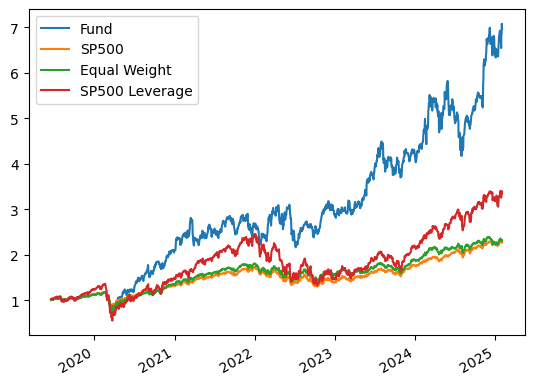

In [20]:
performance['Fund']=historical_portfolio.sum(axis=1)
performance['SP500']=sp500
performance['Equal Weight']=equal_weight.sum(axis=1)
performance['SP500 Leverage']=sp500_leverage

performance_pct=performance.copy()
performance_pct=performance_pct.pct_change()

(1+performance_pct.iloc[:-2]).cumprod().plot()

In [21]:
years=sorted(list(set(performance.index.year)))

In [22]:
month_year=performance.index.strftime('%Y-%m')
month_year=sorted(list(set(month_year)))

In [23]:
(1+performance_pct.loc[str(2025)]).cumprod()

,Fund,SP500,Equal Weight,SP500 Leverage
2025-01-02,0.986980,0.997543,0.998153,0.989125
2025-01-03,1.016574,1.010016,1.013931,0.996917
2025-01-06,1.010207,1.015834,1.017813,1.028380
2025-01-07,0.992848,1.004351,1.009571,1.006377
2025-01-08,0.998337,1.005818,1.011168,0.989421
2025-01-10,0.999829,0.990462,0.995227,0.960260
2025-01-13,0.990275,0.991998,1.000628,0.952278
2025-01-14,1.009663,0.993363,1.008211,0.965370
2025-01-15,1.027710,1.011432,1.022678,0.994763
2025-01-16,1.036534,1.009487,1.029025,1.006377


In [24]:
year_returns={}
for year in years:

    perf_year=performance.loc[str(year)].iloc[-1]/performance.loc[str(year)].iloc[0]-1
    year_returns[year]=perf_year

year_returns[years[-1]]=performance.loc[str(years[-1])].iloc[-2]/performance.loc[str(years[-1])].iloc[0]-1

In [25]:
year_returns_dataframe=pd.DataFrame(year_returns)
year_returns_dataframe

,2019,2020,2021,2022,2023,2024,2025
Fund,0.125325,0.853872,0.246016,0.084856,0.504798,0.571611,0.077388
SP500,0.128370,0.172352,0.305054,-0.186464,0.267092,0.255893,0.022458
Equal Weight,0.125325,0.204215,0.342908,-0.131029,0.216218,0.184268,0.026816
SP500 Leverage,0.232929,0.194817,0.656196,NaN,0.499447,0.484623,0.028435


In [26]:
month_returns={}
for month in month_year:

    perf_year=performance.loc[str(month)].iloc[-1]/performance.loc[str(month)].iloc[0]-1
    month_returns[month]=perf_year

month_returns[month]=performance.loc[str(month_year[-1])].iloc[-2]/performance.loc[str(month_year[-1])].iloc[0]-1

In [27]:
month_returns_dataframe=pd.DataFrame(month_returns)
month_returns_dataframe

,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03,...,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11,2024-12,2025-01,2025-02
Fund,0.023039,0.006979,-0.008713,0.027705,0.029037,0.027415,0.036709,-0.007842,-0.086497,-0.196242,...,0.145463,-0.019727,-0.085913,0.085286,0.071420,0.040990,0.275754,-0.046094,0.099824,0.0
SP500,0.017469,0.005987,-0.008106,0.025454,0.034409,0.026687,0.037872,-0.009666,-0.085956,-0.161197,...,0.054002,0.034437,0.010030,0.038065,0.042457,0.000035,0.055180,-0.025806,0.029386,0.0
Equal Weight,0.023039,0.006979,-0.008713,0.027705,0.029037,0.027415,0.036709,-0.007842,-0.086497,-0.196242,...,0.047360,0.012355,0.030568,0.029409,0.045088,-0.013670,0.074312,-0.064577,0.035579,0.0
SP500 Leverage,0.026310,0.034599,-0.064692,0.053049,0.043229,0.058834,0.069655,-0.004618,-0.203045,-0.291766,...,0.071362,0.086993,0.018843,0.038936,0.054886,0.005852,0.096945,-0.040481,0.067630,0.0


In [28]:
metrics={}
metrics['Tracking Error']=(performance_pct['Fund']-performance_pct['SP500']).std()*np.sqrt(252)
metrics['Fund Vol']=performance_pct['Fund'].std()*np.sqrt(252)
metrics['Bench Vol']=performance_pct['SP500'].std()*np.sqrt(252)
metrics['Fund Return']=performance['Fund'].iloc[-2]/performance['Fund'].iloc[0]
metrics['Bench Return']=performance['SP500'].iloc[-2]/performance['SP500'].iloc[0]
metrics['Sharpe Ratio']=(1+metrics['Fund Return'])**(1/len(set(dataframe.index.year)))/metrics['Fund Vol']

In [29]:
indicators=pd.DataFrame(metrics.values(),index=metrics.keys(),columns=['Indicators'])
indicators

,Indicators
Tracking Error,0.492749
Fund Vol,0.539679
Bench Vol,0.202916
Fund Return,6.828679
Bench Return,2.260376
Sharpe Ratio,2.486191


In [30]:
metrics={}
metrics['Tracking Error']=(performance_pct['Fund']-performance_pct['SP500 Leverage']).std()*np.sqrt(252)
metrics['Fund Vol']=performance_pct['Fund'].std()*np.sqrt(252)
metrics['Bench Vol']=performance_pct['SP500 Leverage'].std()*np.sqrt(252)
metrics['Fund Return']=performance['Fund'].iloc[-2]/performance['Fund'].iloc[0]
metrics['Bench Return']=performance['SP500 Leverage'].iloc[-2]/performance['SP500 Leverage'].iloc[0]
metrics['Sharpe Ratio']=(1+metrics['Fund Return'])**(1/len(set(dataframe.index.year)))/metrics['Fund Vol']

In [31]:
indicators=pd.DataFrame(metrics.values(),index=metrics.keys(),columns=['Indicators'])
indicators

,Indicators
Tracking Error,0.559913
Fund Vol,0.539679
Bench Vol,0.363085
Fund Return,6.828679
Bench Return,3.266766
Sharpe Ratio,2.486191


# Manual Testing

initial_price=dataframe.iloc[0].to_dict()
weight_dict={}
inital_investment_per_stock={}
shares={}
initial_amount=100

perf=dataframe.pct_change()
for col in dataframe.columns:
    
    weight_dict[col]=1/dataframe.shape[1]

    inital_investment_per_stock[col]=weight_dict[col]*initial_amount
    shares[col]=inital_investment_per_stock[col]*(1-0.005)/initial_price[col]
    

t=(dataframe*shares).sum(axis=1).loc[dates_end[1]]
i=1
t

top50=mrat_weights.loc[dates_end[i]].sort_values(ascending=False)[:20]
top_50_rebased=top50/top50.sum()
top_50_rebased=top_50_rebased.to_dict()

inital_investment_per_stock={}
initial_investment=t
shares={}
initial_price=dataframe.loc[dates_end[i]].to_dict()
#tracking[1][3]

weight_dict={}

for col in dataframe.columns:    

    if col in top_50_rebased:
        
        weight_dict[col]=top_50_rebased[col]
    else:
        weight_dict[col]=0
        
weight_vec=np.array(list(weight_dict.values()))


for col in dataframe.columns:    

    inital_investment_per_stock[col]=weight_dict[col]*initial_investment*(1+(perf.loc[dates_end[i]]*weight_vec).sum())
    shares[col]=inital_investment_per_stock[col]*(1-0.005)/initial_price[col]

i=i+1

t=(dataframe*shares).sum(axis=1).loc[dates_end[i]]
t